<a href="https://colab.research.google.com/github/jvtesteves/TransferLearningCatsDogs/blob/main/transferLearningCats%26Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# @title **Notebook: Transfer Learning com Cats vs Dogs**

# ===========================================
#       1. Bibliotecas e Configurações
# ===========================================
import os
import zipfile
import random
import shutil

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

print("Versão do TensorFlow:", tf.__version__)



Versão do TensorFlow: 2.18.0


In [6]:
# ===========================================
#       2. Upload e Descompactação
# ===========================================
# Supondo que o arquivo "kagglecatsanddogs_5340.zip" já está no diretório padrão do Colab (/content)

DATASET_ZIP = "/content/kagglecatsanddogs_5340.zip"

# Descompacta o arquivo na pasta /content
with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
    zip_ref.extractall("/content")

# O dataset extraído normalmente cria uma pasta chamada "PetImages" com subpastas "Cat" e "Dog"
DATASET_DIR = "/content/PetImages"

# Verificando o conteúdo
print("Conteúdo do diretório principal:")
print(os.listdir(DATASET_DIR))

# Verificando subpastas
print("\nSubpastas em PetImages:", os.listdir(DATASET_DIR))


Conteúdo do diretório principal:
['Cat', 'Dog']

Subpastas em PetImages: ['Cat', 'Dog']


In [7]:
# ===========================================
#       3. Organizando as Pastas de Treino e Validação
# ===========================================
# Neste passo, criaremos duas pastas principais: "cats_vs_dogs_data/train" e "cats_vs_dogs_data/validation"
# Cada uma terá as subpastas "Cat" e "Dog".

base_dir = "/content/cats_vs_dogs_data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Cria subpastas
for category in ["Cat", "Dog"]:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

# Normalmente, o dataset "PetImages" contém as pastas "Cat" e "Dog".
original_cats_dir = os.path.join(DATASET_DIR, "Cat")
original_dogs_dir = os.path.join(DATASET_DIR, "Dog")

# Listando os arquivos de cada classe
cat_filenames = [f for f in os.listdir(original_cats_dir) if f.endswith(".jpg")]
dog_filenames = [f for f in os.listdir(original_dogs_dir) if f.endswith(".jpg")]

# Removendo possíveis arquivos corrompidos (por segurança)
def is_valid_image(filepath):
    try:
        img = tf.io.read_file(filepath)
        img = tf.io.decode_jpeg(img)
    except:
        return False
    return True

cat_filenames_full = [os.path.join(original_cats_dir, f) for f in cat_filenames]
dog_filenames_full = [os.path.join(original_dogs_dir, f) for f in dog_filenames]

cat_filenames_valid = [f for f in cat_filenames_full if is_valid_image(f)]
dog_filenames_valid = [f for f in dog_filenames_full if is_valid_image(f)]

print("Total de imagens de gato após verificação:", len(cat_filenames_valid))
print("Total de imagens de cachorro após verificação:", len(dog_filenames_valid))

# Vamos dividir em 80% treino e 20% validação (você pode ajustar se desejar)
split_ratio = 0.8

# Função auxiliar para mover arquivos
def split_data(file_list, train_path, val_path, category):
    random.shuffle(file_list)
    split_index = int(len(file_list) * split_ratio)
    train_files = file_list[:split_index]
    val_files = file_list[split_index:]

    for file in train_files:
        shutil.copy(file, os.path.join(train_path, category))

    for file in val_files:
        shutil.copy(file, os.path.join(val_path, category))

split_data(cat_filenames_valid, train_dir, val_dir, "Cat")
split_data(dog_filenames_valid, train_dir, val_dir, "Dog")

print("\nOrganização concluída!")
print("Pasta de treino (Cats):", len(os.listdir(os.path.join(train_dir, "Cat"))))
print("Pasta de treino (Dogs):", len(os.listdir(os.path.join(train_dir, "Dog"))))
print("Pasta de validação (Cats):", len(os.listdir(os.path.join(val_dir, "Cat"))))
print("Pasta de validação (Dogs):", len(os.listdir(os.path.join(val_dir, "Dog"))))


Total de imagens de gato após verificação: 12427
Total de imagens de cachorro após verificação: 12397

Organização concluída!
Pasta de treino (Cats): 9941
Pasta de treino (Dogs): 9917
Pasta de validação (Cats): 2486
Pasta de validação (Dogs): 2480


In [8]:
# ===========================================
#       4. Criação dos Geradores de Imagem
# ===========================================
# Iremos usar o ImageDataGenerator para:
# 1) Redimensionar as imagens.
# 2) Normalizar os pixels.
# 3) Aplicar Data Augmentation no conjunto de treino.

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Para classificação binária
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 19858 images belonging to 2 classes.
Found 4966 images belonging to 2 classes.


In [9]:
# ===========================================
#       5. Construindo o Modelo (Transfer Learning)
# ===========================================
# Utilizaremos o MobileNetV2 pré-treinado no ImageNet.
# Vamos remover a top layer e adicionar novas camadas para classificar Cat vs Dog.

base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)

# Congelar as camadas do modelo base (para treinar apenas as camadas finais que adicionaremos)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  # Camada final binária
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
456/621 ━━━━━━━━━━━━━━━━━━━━ 4:57 2s/step - accuracy: 0.9162 - loss: 0.1976

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


621/621 ━━━━━━━━━━━━━━━━━━━━ 1351s 2s/step - accuracy: 0.9275 - loss: 0.1740 - val_accuracy: 0.9821 - val_loss: 0.0518
Epoch 2/5
621/621 ━━━━━━━━━━━━━━━━━━━━ 1361s 2s/step - accuracy: 0.9729 - loss: 0.0698 - val_accuracy: 0.9839 - val_loss: 0.0477
Epoch 3/5
621/621 ━━━━━━━━━━━━━━━━━━━━ 1318s 2s/step - accuracy: 0.9752 - loss: 0.0675 - val_accuracy: 0.9795 - val_loss: 0.0561
Epoch 4/5
621/621 ━━━━━━━━━━━━━━━━━━━━ 1283s 2s/step - accuracy: 0.9770 - loss: 0.0602 - val_accuracy: 0.9815 - val_loss: 0.0509
Epoch 5/5
621/621 ━━━━━━━━━━━━━━━━━━━━ 1280s 2s/step - accuracy: 0.9739 - loss: 0.0621 - val_accuracy: 0.9835 - val_loss: 0.0469


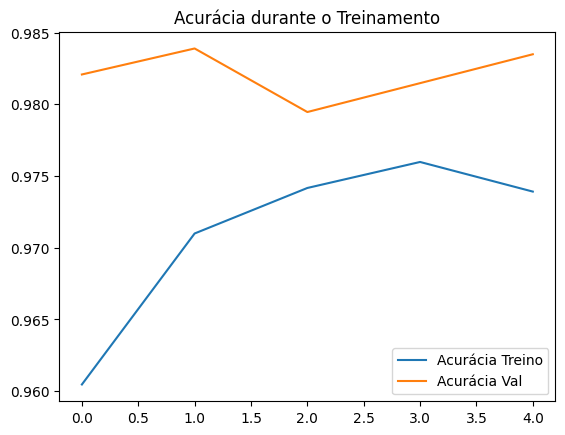

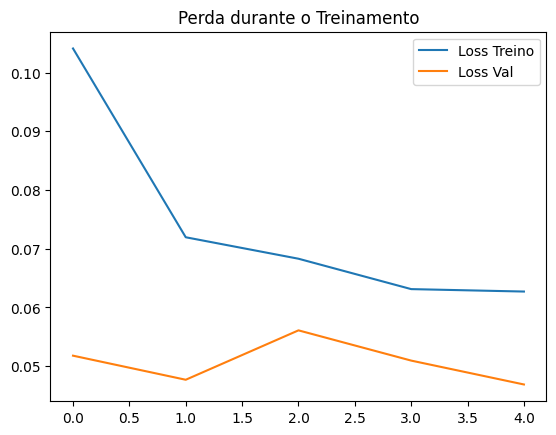

In [10]:
# ===========================================
#       6. Treinamento do Modelo
# ===========================================
EPOCHS = 5

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

# Curva de treinamento
plt.figure()
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Val')
plt.title('Acurácia durante o Treinamento')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Loss Treino')
plt.plot(history.history['val_loss'], label='Loss Val')
plt.title('Perda durante o Treinamento')
plt.legend()
plt.show()


In [11]:
# ===========================================
#       8. Avaliação e Salvando o Modelo
# ===========================================
loss, accuracy = model.evaluate(val_generator)
print(f"Acurácia final no conjunto de validação: {accuracy*100:.2f}%")

# Salvar o modelo treinado
model.save("modelo_transfer_learning_cats_dogs.h5")
print("Modelo salvo como 'modelo_transfer_learning_cats_dogs.h5'")


156/156 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.9837 - loss: 0.0498


Acurácia final no conjunto de validação: 98.35%
Modelo salvo como 'modelo_transfer_learning_cats_dogs.h5'


# ===========================================
#       9. Conclusão
# ===========================================
#
# Neste notebook, demonstramos como:
# 1) Descompactar o dataset "kagglecatsanddogs_5340.zip" no Google Colab;
# 2) Organizar as imagens em pastas de treino e validação (Cat e Dog);
# 3) Construir um modelo de Transfer Learning usando MobileNetV2 pré-treinado no ImageNet;
# 4) Realizar o treinamento e opcionalmente o fine tuning do modelo;
# 5) Avaliar e salvar o modelo para uso posterior.

